In [1]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_columns = None
import seaborn as sns
from sklearn.model_selection import train_test_split
GLOBAL_RANDOM_STATE=42
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, cohen_kappa_score, hamming_loss, f1_score, precision_score

In [2]:
data = pd.read_csv("data2.csv",sep=";")
data.head()

,Date,Value
0,01.05.2014,0
1,02.05.2014,10
2,03.05.2014,0
3,04.05.2014,0
4,05.05.2014,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
Date     1461 non-null object
Value    1461 non-null int64
dtypes: int64(1), object(1)
memory usage: 22.9+ KB


In [4]:
data["Date"] = pd.to_datetime(data.Date, format="%d.%m.%Y")
data.head()

,Date,Value
0,2014-05-01,0
1,2014-05-02,10
2,2014-05-03,0
3,2014-05-04,0
4,2014-05-05,0


In [5]:
data_test = data.tail(1).copy()
data_test.Date = data_test.Date + pd.to_timedelta(1, unit='d')
data_test.Value = -1

In [6]:
for i in range(365):
    tmp_df = pd.DataFrame({
        "Date": data_test.tail(1).Date + pd.to_timedelta(1, unit='d'),
        "Value": -1
    })
    data_test = pd.concat([data_test, tmp_df])

In [7]:
data['year'] = pd.DatetimeIndex(data['Date']).year
data.head()

,Date,Value,year
0,2014-05-01,0,2014
1,2014-05-02,10,2014
2,2014-05-03,0,2014
3,2014-05-04,0,2014
4,2014-05-05,0,2014


In [8]:
data_test['year'] = pd.DatetimeIndex(data_test['Date']).year
data_test.head()

,Date,Value,year
1460,2018-05-01,-1,2018
1460,2018-05-02,-1,2018
1460,2018-05-03,-1,2018
1460,2018-05-04,-1,2018
1460,2018-05-05,-1,2018


In [9]:
data['month'] = pd.DatetimeIndex(data['Date']).month
data.head()

,Date,Value,year,month
0,2014-05-01,0,2014,5
1,2014-05-02,10,2014,5
2,2014-05-03,0,2014,5
3,2014-05-04,0,2014,5
4,2014-05-05,0,2014,5


In [10]:
data_test['month'] = pd.DatetimeIndex(data_test['Date']).month
data_test.head()

,Date,Value,year,month
1460,2018-05-01,-1,2018,5
1460,2018-05-02,-1,2018,5
1460,2018-05-03,-1,2018,5
1460,2018-05-04,-1,2018,5
1460,2018-05-05,-1,2018,5


In [11]:
data['dayofweek'] = pd.DatetimeIndex(data['Date']).dayofweek
data.head()

,Date,Value,year,month,dayofweek
0,2014-05-01,0,2014,5,3
1,2014-05-02,10,2014,5,4
2,2014-05-03,0,2014,5,5
3,2014-05-04,0,2014,5,6
4,2014-05-05,0,2014,5,0


In [12]:
data_test['dayofweek'] = pd.DatetimeIndex(data_test['Date']).dayofweek
data_test.head()

,Date,Value,year,month,dayofweek
1460,2018-05-01,-1,2018,5,1
1460,2018-05-02,-1,2018,5,2
1460,2018-05-03,-1,2018,5,3
1460,2018-05-04,-1,2018,5,4
1460,2018-05-05,-1,2018,5,5


In [13]:
data['day'] = pd.DatetimeIndex(data['Date']).day
data.head()

,Date,Value,year,month,dayofweek,day
0,2014-05-01,0,2014,5,3,1
1,2014-05-02,10,2014,5,4,2
2,2014-05-03,0,2014,5,5,3
3,2014-05-04,0,2014,5,6,4
4,2014-05-05,0,2014,5,0,5


In [14]:
data_test['day'] = pd.DatetimeIndex(data_test['Date']).day
data_test.head()

,Date,Value,year,month,dayofweek,day
1460,2018-05-01,-1,2018,5,1,1
1460,2018-05-02,-1,2018,5,2,2
1460,2018-05-03,-1,2018,5,3,3
1460,2018-05-04,-1,2018,5,4,4
1460,2018-05-05,-1,2018,5,5,5


In [15]:
# data['yearmonth'] = data.year + (data.month-1)/12
# data.head()

In [16]:
correlation = data.corr(method='pearson')
columns = correlation.nlargest(10, 'Value').index
columns

Index(['Value', 'month', 'dayofweek', 'day', 'year'], dtype='object')

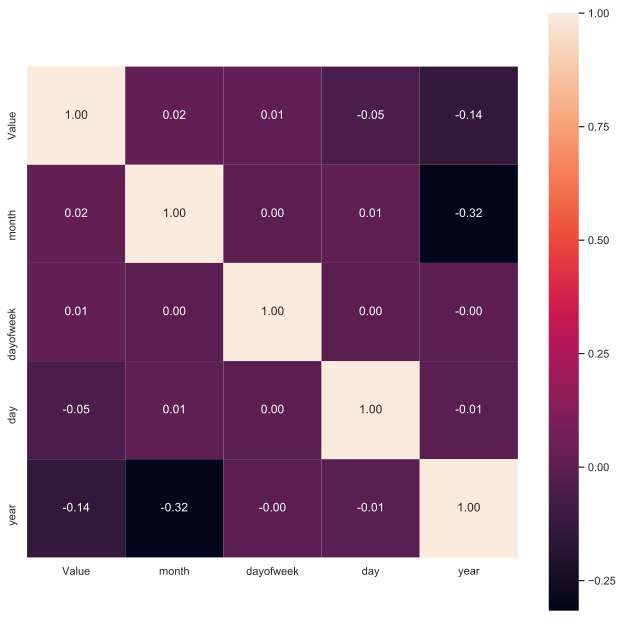

In [17]:
sns.set(rc={'figure.figsize':(11.,11.)})
correlation_map = np.corrcoef(data[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

In [18]:
years = sorted(data.year.unique().tolist())
years

[2014, 2015, 2016, 2017, 2018]

In [19]:
months = sorted(data.month.unique().tolist())
months

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [20]:
year_sums = []
yearmonth_sums = []
yearmonth_avgs = []
yearmonth_medians = []
yearmonth_modes = []
yearmonth_x = []

for year in years:
    year_data = data[data.year==year].copy()
    year_sums.append(year_data.Value.sum())
    for month in months:
        yearmonth_data = year_data[year_data.month==month]
#         yearmonth_x.append(str(year)+"-"+str(month))
        yearmonth_x.append(year + (float(month)-1)/12)
        yearmonth_sums.append(yearmonth_data.Value.sum())
        yearmonth_avgs.append(yearmonth_data.Value.mean())
        yearmonth_medians.append(yearmonth_data.Value.median())
        if len(yearmonth_data)>0:
            yearmonth_modes.append(yearmonth_data.Value.mode()[0])
        else:
            yearmonth_modes.append(0)
    

In [21]:
yearmonth_sums = yearmonth_sums[4:]
yearmonth_sums = yearmonth_sums[:-8]

yearmonth_avgs = yearmonth_avgs[4:]
yearmonth_avgs = yearmonth_avgs[:-8]

yearmonth_medians = yearmonth_medians[4:]
yearmonth_medians = yearmonth_medians[:-8]

yearmonth_modes = yearmonth_modes[4:]
yearmonth_modes = yearmonth_modes[:-8]

yearmonth_x = yearmonth_x[4:]
yearmonth_x = yearmonth_x[:-8]

In [22]:
some_info = pd.DataFrame({"x": yearmonth_x, "sum": yearmonth_sums, "avg": yearmonth_avgs, "median": yearmonth_medians, "mode": yearmonth_modes})

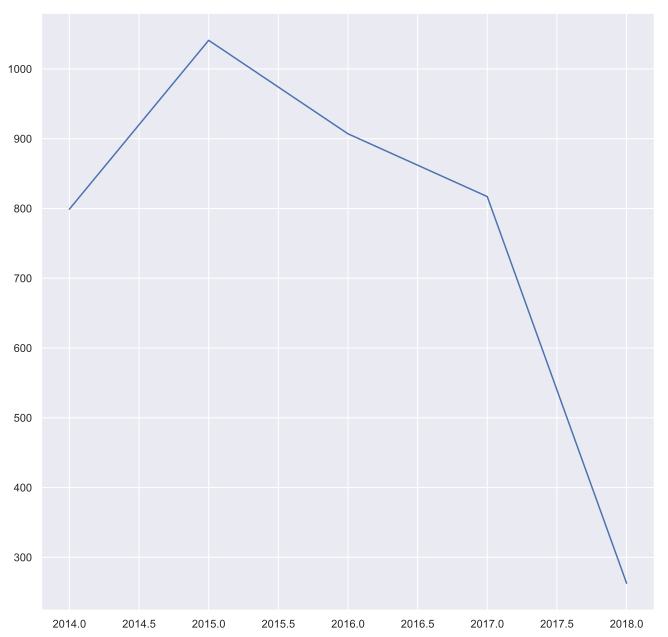

In [23]:
plt.plot(years, year_sums)
plt.show()

## На графике сумм значений по отношению к годам мы видим нисходящую тенденцию, но из-за того что года "по краям" взяты не сначала и не до конца график резок.

## Рассмотрим отношение сумм значений по отношению к месяцам:

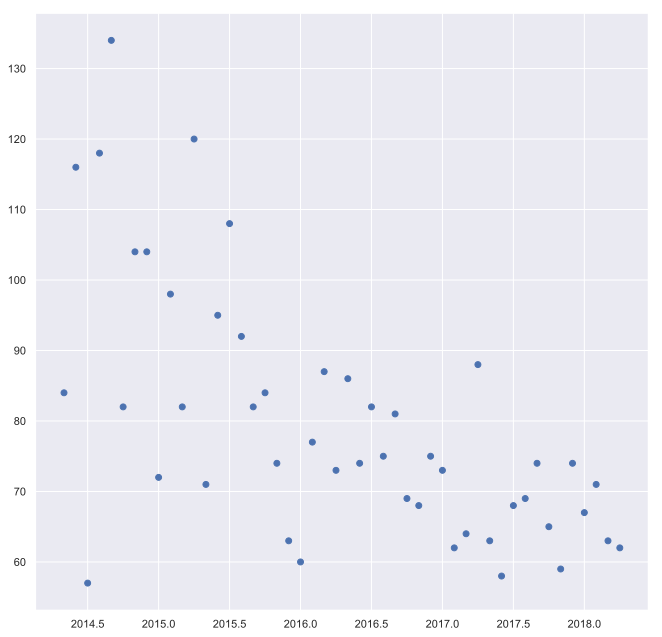

In [24]:
plt.scatter(yearmonth_x, yearmonth_sums)
plt.show()

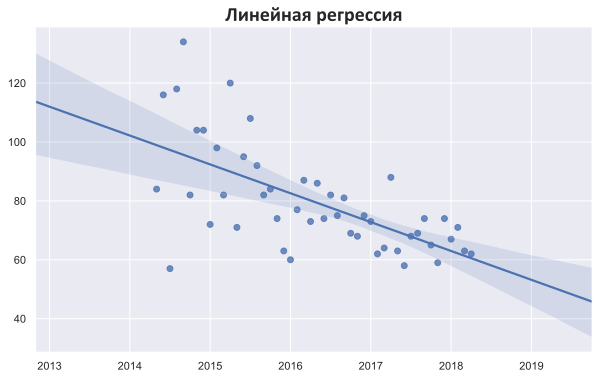

In [25]:
title_dict = {'fontsize': 20, 'fontweight': 'bold', 'family': 'Calibri'}
plt.figure(figsize=(10, 6))
sns.regplot(x=yearmonth_x, y=yearmonth_sums)
plt.title('Линейная регрессия', fontdict=title_dict);
plt.show()

## На графике по месяцам более четко прослеживается нисходящая тенденция по сумме значений, что также подтверждается графиком линейной регрессии 

In [26]:
input_columns_names = data.columns.tolist()[2:]
input_columns_names

['year', 'month', 'dayofweek', 'day']

In [27]:
output_column_name = "Value"
output_column_name

'Value'

In [28]:
parameters = {"n_estimators": [100, 200, 300, 500, 1000],
             "learning_rate": [0.0001, 0.001, 0.01, 0.1],
              "max_depth": [2,3,4,5],
              "max_features": [1,2,3,4]
             }
parameters

{'n_estimators': [100, 200, 300, 500, 1000],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1],
 'max_depth': [2, 3, 4, 5],
 'max_features': [1, 2, 3, 4]}

In [29]:
kfold = KFold(n_splits=3, random_state=GLOBAL_RANDOM_STATE, shuffle=True)
clean_data_gbr_gridsearch = GridSearchCV(estimator=GradientBoostingClassifier(random_state=GLOBAL_RANDOM_STATE),
                                        param_grid=parameters,
                                        cv=kfold,
                                        n_jobs=-1,
                                         verbose=1)
start_time = time.time()
clean_data_gbr_gridsearch.fit(data[input_columns_names], data[output_column_name])
print("Train time: %.3f" % (time.time()-start_time))
gbr_clean_data_best_params = clean_data_gbr_gridsearch.best_params_
gbr_clean_data_best_params

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  7.0min finished


Train time: 423.073


{'learning_rate': 0.01, 'max_depth': 2, 'max_features': 3, 'n_estimators': 500}

## Кросс валидация показала, что лучший результат классификации при таких параметрах GradientBoostingClassifier:  
{'learning_rate': 0.01, 'max_depth': 2, 'max_features': 3, 'n_estimators': 500}

In [30]:
clf = clean_data_gbr_gridsearch
means_test = clf.cv_results_['mean_test_score']
stds_test = clf.cv_results_['std_test_score']

means_train = clf.cv_results_['mean_train_score']
stds_train = clf.cv_results_['std_train_score']

for mean_tst, std_tst, mean_trn, std_trn, params in zip(means_test, stds_test, means_train, stds_train, clf.cv_results_['params']):
    print("Test: %0.3f; Train: %0.3f; Params: %r" % (mean_tst, mean_trn, params))

Test: 0.414; Train: 0.414; Params: {'learning_rate': 0.0001, 'max_depth': 2, 'max_features': 1, 'n_estimators': 100}
Test: 0.414; Train: 0.414; Params: {'learning_rate': 0.0001, 'max_depth': 2, 'max_features': 1, 'n_estimators': 200}
Test: 0.414; Train: 0.414; Params: {'learning_rate': 0.0001, 'max_depth': 2, 'max_features': 1, 'n_estimators': 300}
Test: 0.414; Train: 0.414; Params: {'learning_rate': 0.0001, 'max_depth': 2, 'max_features': 1, 'n_estimators': 500}
Test: 0.414; Train: 0.414; Params: {'learning_rate': 0.0001, 'max_depth': 2, 'max_features': 1, 'n_estimators': 1000}
Test: 0.414; Train: 0.414; Params: {'learning_rate': 0.0001, 'max_depth': 2, 'max_features': 2, 'n_estimators': 100}
Test: 0.414; Train: 0.414; Params: {'learning_rate': 0.0001, 'max_depth': 2, 'max_features': 2, 'n_estimators': 200}
Test: 0.414; Train: 0.414; Params: {'learning_rate': 0.0001, 'max_depth': 2, 'max_features': 2, 'n_estimators': 300}
Test: 0.414; Train: 0.414; Params: {'learning_rate': 0.0001, 'm

C:\Users\pomaz\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\pomaz\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [31]:
gbc_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=2, max_features=3, n_estimators=500, random_state=GLOBAL_RANDOM_STATE)

In [32]:
gbc_model.fit(data[input_columns_names], data[output_column_name])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=2,
              max_features=3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [33]:
pd.DataFrame([gbc_model.predict(data[input_columns_names]).tolist(), data[output_column_name].tolist()])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [34]:
accuracy_score(data[output_column_name].tolist(), gbc_model.predict(data[input_columns_names]).tolist())

0.48323066392881586

In [35]:
cohen_kappa_score(data[output_column_name].tolist(), gbc_model.predict(data[input_columns_names]).tolist())

0.19051459569577767

In [36]:
hamming_loss(data[output_column_name].tolist(), gbc_model.predict(data[input_columns_names]).tolist())

0.5167693360711841

In [37]:
f1_score(data[output_column_name].tolist(), gbc_model.predict(data[input_columns_names]).tolist(), average=None)

C:\Users\pomaz\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.49479167, 0.64930748, 0.02564103, 0.01652893, 0.        ,
       0.19689119, 0.11428571, 0.05      , 0.        , 0.        ,
       0.        ])

In [38]:
precision_score(data[output_column_name].tolist(), gbc_model.predict(data[input_columns_names]).tolist(), average=None)

C:\Users\pomaz\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.48969072, 0.48833333, 0.25      , 1.        , 0.        ,
       0.34545455, 1.        , 1.        , 0.        , 0.        ,
       0.        ])

In [39]:
f1_score(data[output_column_name].tolist(), gbc_model.predict(data[input_columns_names]).tolist(), average='micro')

0.48323066392881586

In [40]:
precision_score(data[output_column_name].tolist(), gbc_model.predict(data[input_columns_names]).tolist(), average='micro')

0.48323066392881586

In [41]:
predicted_values = gbc_model.predict(data_test[input_columns_names])

In [42]:
data_test["date_x"] = data_test.year + (data_test.month - 1)/12

In [43]:
data_test["Value"] = predicted_values
data_test.head()

,Date,Value,year,month,dayofweek,day,date_x
1460,2018-05-01,1,2018,5,1,1,2018.333333
1460,2018-05-02,1,2018,5,2,2,2018.333333
1460,2018-05-03,1,2018,5,3,3,2018.333333
1460,2018-05-04,1,2018,5,4,4,2018.333333
1460,2018-05-05,1,2018,5,5,5,2018.333333


In [44]:
new_years = sorted(data_test.year.unique().tolist())
new_year_sums = []
new_yearmonth_sums = []

for year in new_years:
    year_data = data_test[data_test.year==year].copy()
    new_year_sums.append(year_data.Value.sum())
    for month in months:
        yearmonth_data = year_data[year_data.month==month]
        new_yearmonth_sums.append(yearmonth_data.Value.sum())

In [45]:
new_yearmonth_sums = new_yearmonth_sums[4:]
new_yearmonth_sums = new_yearmonth_sums[:-7]
new_yearmonth_sums

[31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 1]

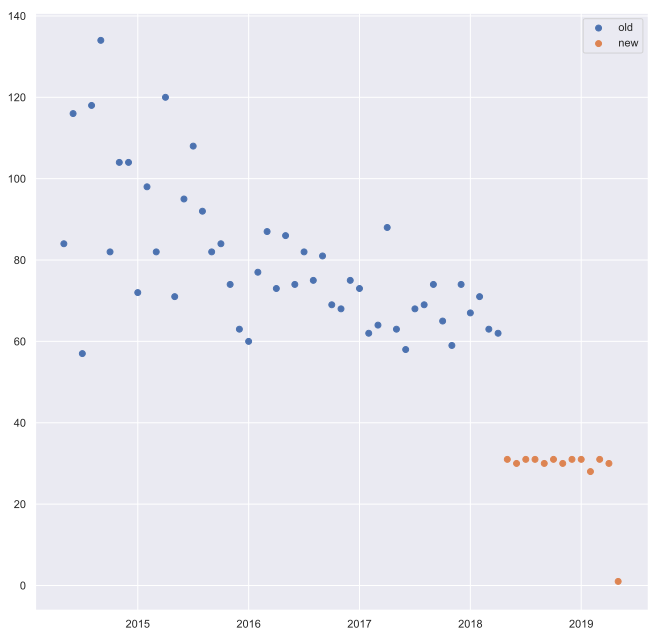

In [46]:
plt.scatter(yearmonth_x, yearmonth_sums, label="old")
plt.scatter(sorted(data_test.date_x.unique().tolist()), new_yearmonth_sums, label="new")
plt.legend()
plt.show()

## Модель плохо отработала на предсказании будущих результатов. Думаю это связано с тем, что модель получила на вход данные за пределами значений на которых она обучалась, отсюда и плохой результат.

## Таким образом более менее правильные данные прогноза можно получить используя формулу линейной регрессии, полученную ранее. Эти значения будут лежать на прямой.